# Mixture of Experts Experiments
### Fault characterization, prediction, and mitigation for LLM training and inference using MoE architectures

Dylan Everingham, TU Berlin Distributed and Operating Systems (DOS)

everingham@tu-berlin.de

02.02.2026

In [1]:
from experiments import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Set seeds
seed = 100
np.random.seed(seed);
torch.manual_seed(seed);

Total Trainable Params: 1895790


Epoch 1: 100%|████| 146/146 [00:07<00:00, 19.11it/s, accuracy=0.0469, loss=6.12]


Epoch: 1, Train loss: 6.112, Train acc: 0.045, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.740s


Epoch 2: 100%|████| 146/146 [00:07<00:00, 19.61it/s, accuracy=0.0469, loss=5.88]


Epoch: 2, Train loss: 5.719, Train acc: 0.051, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.540s


Epoch 3: 100%|████| 146/146 [00:07<00:00, 19.91it/s, accuracy=0.0347, loss=5.74]


Epoch: 3, Train loss: 5.633, Train acc: 0.053, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.432s


Epoch 4: 100%|████| 146/146 [00:07<00:00, 19.73it/s, accuracy=0.0347, loss=5.72]


Epoch: 4, Train loss: 5.564, Train acc: 0.057, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.495s


Epoch 5: 100%|████| 146/146 [00:07<00:00, 19.43it/s, accuracy=0.0191, loss=5.68]


Epoch: 5, Train loss: 5.598, Train acc: 0.064, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.608s


Epoch 6: 100%|█████| 146/146 [00:07<00:00, 19.15it/s, accuracy=0.0191, loss=5.6]


Epoch: 6, Train loss: 5.521, Train acc: 0.070, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.720s


Epoch 7: 100%|████| 146/146 [00:07<00:00, 18.71it/s, accuracy=0.0226, loss=5.43]


Epoch: 7, Train loss: 5.398, Train acc: 0.090, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.900s


Epoch 8: 100%|████| 146/146 [00:07<00:00, 19.19it/s, accuracy=0.0295, loss=5.23]


Epoch: 8, Train loss: 5.192, Train acc: 0.108, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.700s


Epoch 9: 100%|████| 146/146 [00:07<00:00, 19.25it/s, accuracy=0.0503, loss=5.05]


Epoch: 9, Train loss: 4.862, Train acc: 0.129, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.686s


Epoch 10: 100%|████| 146/146 [00:07<00:00, 19.16it/s, accuracy=0.066, loss=4.74]


Epoch: 10, Train loss: 4.533, Train acc: 0.160, Val acc: 0.000, Val gen acc: 0.000 Epoch time = 7.717s


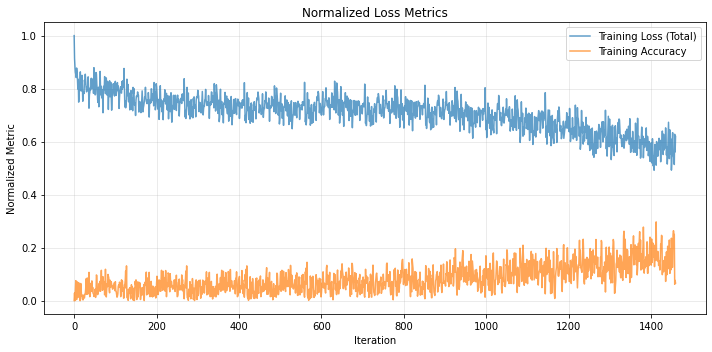

In [3]:
(model, tokenizer,
 args, history) = \
run_experiment_train(model_type=DecoderOnlyLM,
                     task='text_generation',
                     enable_wandb=False)

#run_experiment_train_basic_decoderonly_text(enable_wandb=False)

In [6]:
start_context = "I have "

output_text = generate_text(
    model=model,
    tokenizer=tokenizer,
    start_context=start_context,
    max_length=20
)

final_text = start_context + output_text

print("Final text:", final_text)

Final text: I have<|SOS|> I have been have been that I had been have been have been have been have been that I had been that


In [5]:
test_generation_reverse(model, n_samples=10)

  0%|                                                    | 0/10 [00:00<?, ?it/s]


KeyError: 970

In [ ]:
#run_experiment_inference(model_basic)